In [5]:
%%capture
!pip3 install -r requirements.txt

### Individual Discriminators

Initially, each dataset ("inpainting", "insight", "text2img") was trained separately with its own dedicated discriminator model. Each discriminator specialized in distinguishing real images from generated ones within a specific dataset. The training and saving were performed as follows:


```python
    folders = ["inpainting", "insight", "text2img"]

    for name in folders:
        train_df, test_df = get_train_test(real="data/wiki/", fake=f"data/{name}/")

        single_train_discriminator = Discriminator(image_size=512)
        single_train_discriminator.fit(train_df, val_split=0.2, epochs=15)
        single_train_discriminator.save(f"models/discriminator_{name}.pth")
        
```

Here are the results for the individual Discriminators:

,precision,recall,f1-score,support
0,0.997669,0.998500,0.998084,6000.000000
1,0.998499,0.997667,0.998083,6000.000000
accuracy,0.998083,0.998083,0.998083,0.998083
macro avg,0.998084,0.998083,0.998083,12000.000000
weighted avg,0.998084,0.998083,0.998083,12000.000000


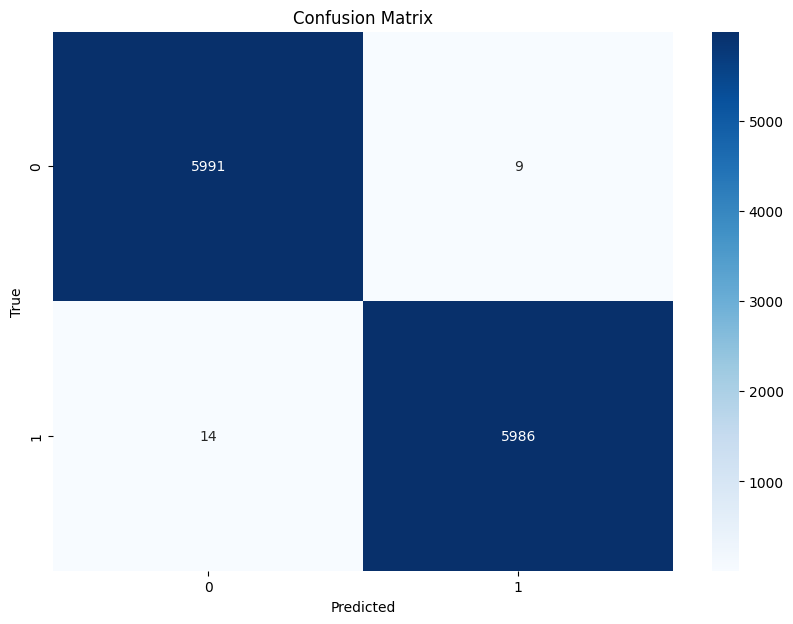

In [6]:
from utils import get_train_test, get_classification_report, plot_confusion_matrix
from GAN import Discriminator


folder = "inpainting"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)

,precision,recall,f1-score,support
0,0.998002,0.9990,0.998501,6000.0000
1,0.998999,0.9980,0.998499,6000.0000
accuracy,0.998500,0.9985,0.998500,0.9985
macro avg,0.998500,0.9985,0.998500,12000.0000
weighted avg,0.998500,0.9985,0.998500,12000.0000


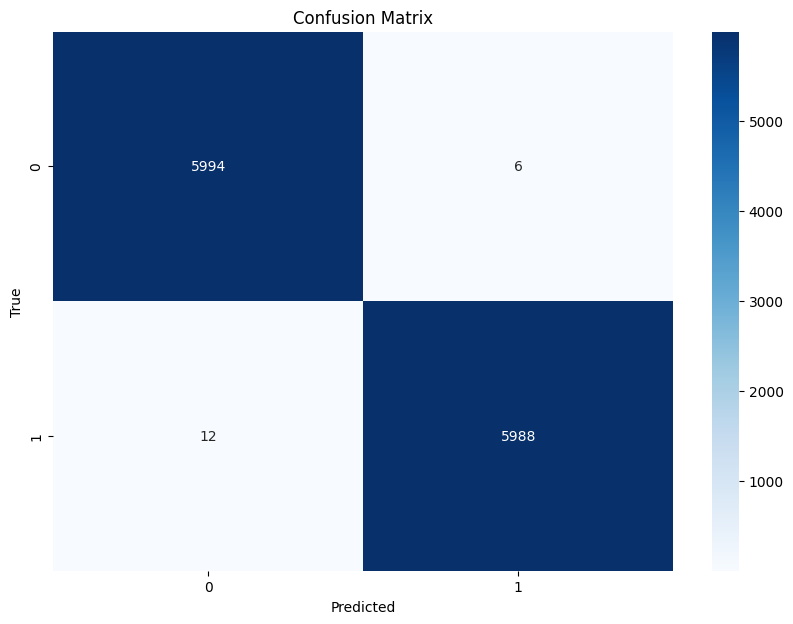

In [ ]:
from utils import get_train_test, get_classification_report, plot_confusion_matrix
from GAN import Discriminator

folder = "insight"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)


,precision,recall,f1-score,support
0,0.999001,0.999833,0.999417,6000.000000
1,0.999833,0.999000,0.999416,6000.000000
accuracy,0.999417,0.999417,0.999417,0.999417
macro avg,0.999417,0.999417,0.999417,12000.000000
weighted avg,0.999417,0.999417,0.999417,12000.000000


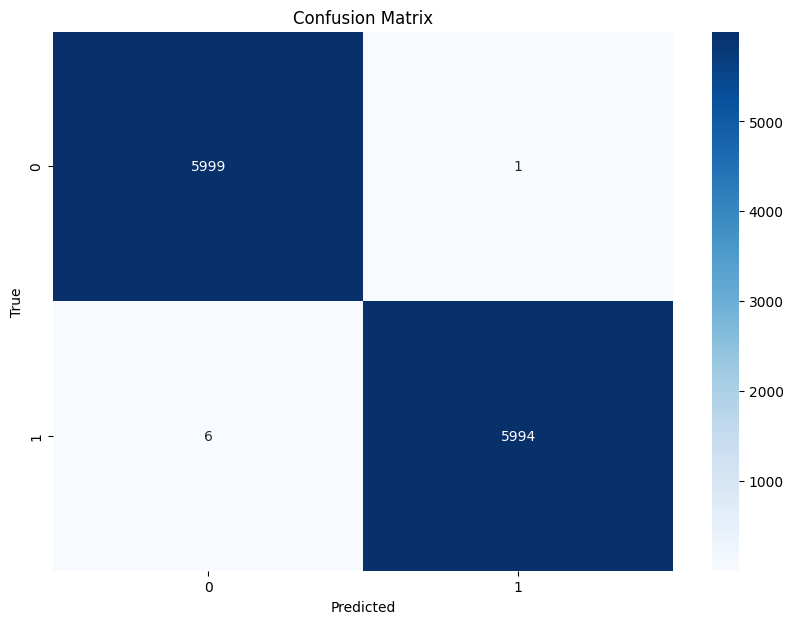

In [ ]:
from utils import get_train_test, get_classification_report, plot_confusion_matrix
from GAN import Discriminator

folder = "text2img"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)

### Unified Discriminator Training

After training individual discriminators separately on distinct datasets, we required a single unified discriminator capable of accurately distinguishing images from all datasets simultaneously. To achieve this, we sequentially fine-tuned one discriminator across each dataset as follows:

```python
    unified_discriminator = Discriminator(image_size=512)
    folders = ["inpainting", "insight","text2img"]
    for name in folders:
        train_df, test_df = get_train_test(real="data/wiki/", fake=f"data/{name}/")
        unified_discriminator.fit(train_df, val_split=0.2, epochs=10)
        
    unified_discriminator.save(f"models/discriminator_full.pth")
```

Why this approach?

- Improved Generalization: Training the discriminator sequentially across multiple datasets helps it learn generalized features rather than dataset-specific biases, resulting in robust performance across varied inputs.

- Efficiency and Reusability: A unified discriminator simplifies deployment and reduces model complexity compared to maintaining multiple dataset-specific discriminators.

Training the discriminator sequentially across each dataset ensures it does not repeatedly encounter the same images within an epoch, reducing redundancy. Additionally, this method avoids class imbalance that could occur by training the real images simultaneously against all the fake datasets.


#### Now let's test it:

Results for inpainting folder:


,precision,recall,f1-score,support
0,0.997626,0.980667,0.989074,6000.000000
1,0.980990,0.997667,0.989258,6000.000000
accuracy,0.989167,0.989167,0.989167,0.989167
macro avg,0.989308,0.989167,0.989166,12000.000000
weighted avg,0.989308,0.989167,0.989166,12000.000000


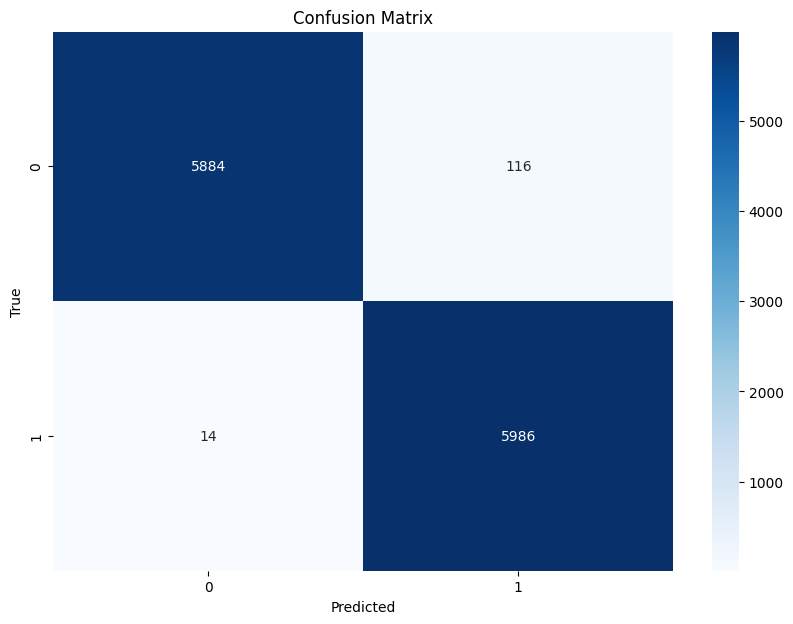

Results for insight folder:


,precision,recall,f1-score,support
0,0.997495,0.929167,0.962119,6000.000000
1,0.933708,0.997667,0.964628,6000.000000
accuracy,0.963417,0.963417,0.963417,0.963417
macro avg,0.965601,0.963417,0.963374,12000.000000
weighted avg,0.965601,0.963417,0.963374,12000.000000


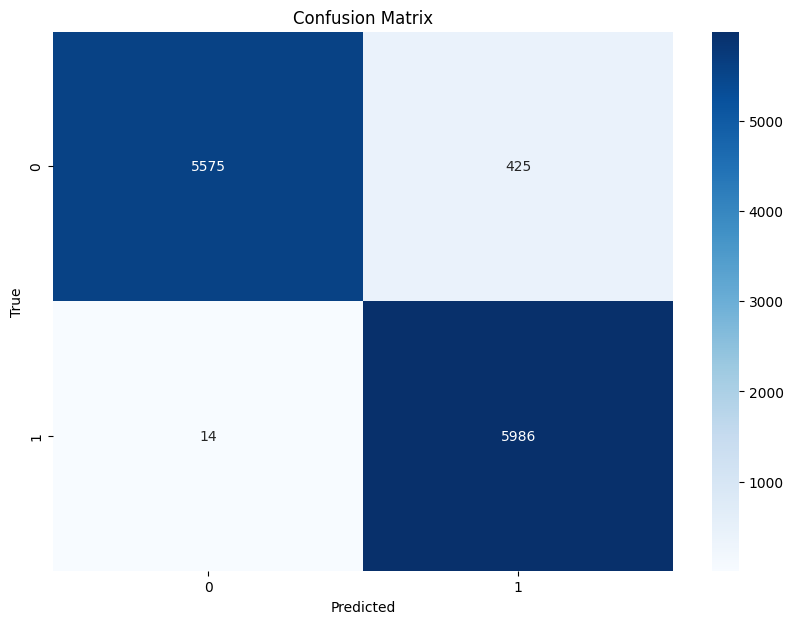

Results for text2img folder:


,precision,recall,f1-score,support
0,0.997667,0.997667,0.997667,6000.000000
1,0.997667,0.997667,0.997667,6000.000000
accuracy,0.997667,0.997667,0.997667,0.997667
macro avg,0.997667,0.997667,0.997667,12000.000000
weighted avg,0.997667,0.997667,0.997667,12000.000000


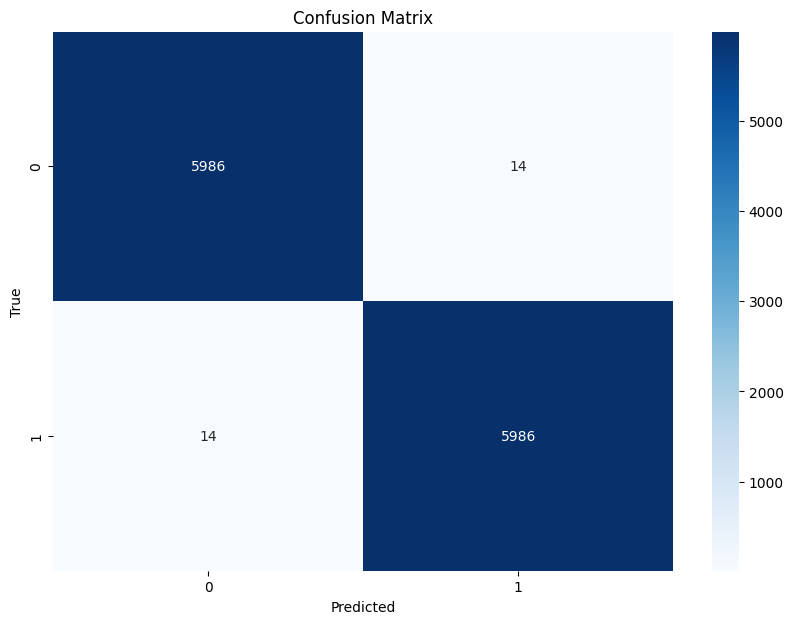

In [ ]:
from utils import get_train_test, get_classification_report, plot_confusion_matrix
from GAN import Discriminator

folders = ["inpainting", "insight", "text2img"]

discriminator = Discriminator.load(f"models/discriminator_full.pth")
for folder in folders:
    _, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
    pred_df = discriminator.predict(test_df)
    print(f"Results for {folder} folder:")
    display(get_classification_report(pred_df))
    plot_confusion_matrix(pred_df)

### GAN training

To train the GAN we used the [Celeba Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?resource=download). 


```python
    path = "data/celeba/"
    all_files = sorted([
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.endswith(".jpg")
    ])
    df = pd.DataFrame({"path": all_files, "label": 1})

    gan = GAN(latent_dim=128)
    
    gan.fit(dataframe=df)

    os.makedirs("models", exist_ok=True)
    gan.save("models/gan/")
```

As explained in the report this is the best Generator we could train. Let's showcase the generation:

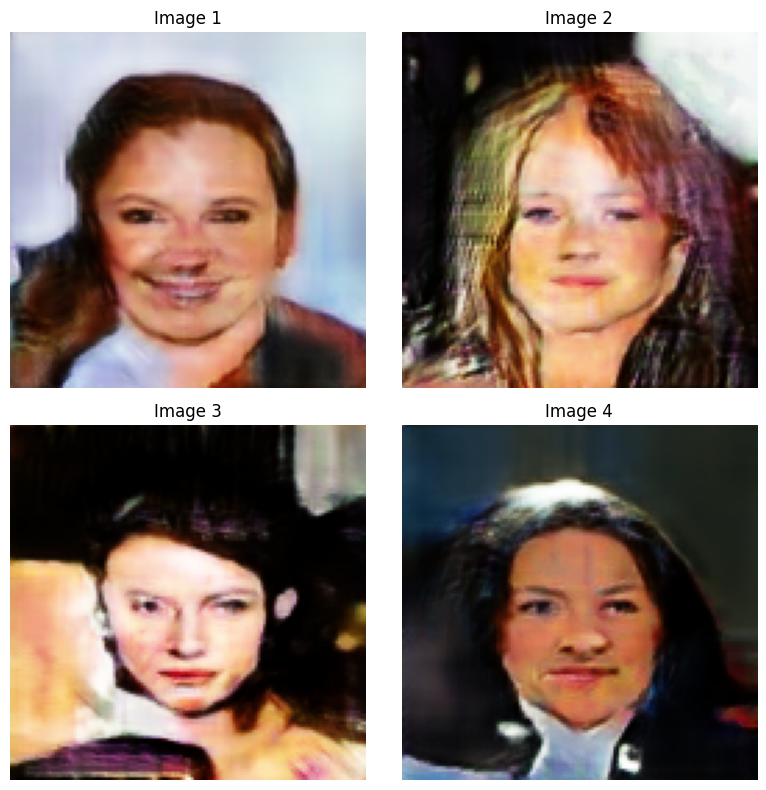

In [ ]:
from GAN import Generator

generator = Generator.load("models/gan/generator.pth")

generator.generate(num_images=4)